# EEG Feature Extraction

In [13]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import scipy.io as sio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cPickle 

In [7]:
import scipy.stats as ss
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression as LogReg
from sklearn.ensemble import RandomForestClassifier as RF

In [8]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingClassifier as Bagging

In [9]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.fftpack import fft 
import scipy
from sklearn.metrics import roc_curve
from sklearn.ensemble import GradientBoostingClassifier as GDB
%matplotlib inline

In [12]:
#set fold path
folder = './data/Patient_1 2/'

# Description

Intotal, we extract 8 features from EEG signal in both time and frequency domain.

Time: 
- Total time energy: Sum of squared magnitude in time domain.
- Time mean (abs): Mean of absolute magnitude of time domain.
- Time variance: Variance of absolute magnitude of time domain.

Frequency: 

- Brightness: Percentage of energy above 25Hz.
- Entropy: We divide the frequency range (0-2.5kHz) into 8 frequency bands. Fundamental requency 0Hz, 0-10Hz, 10-50Hz, 50-100Hz, 100-200Hz, 200-300Hz, 300-400Hz, 400-2500Hz. I both looked at the frequency plot and did several trials and find this division works better in separating the two classes.
- Kurtosis: Fourth standardized moment, https://en.wikipedia.org/wiki/Kurtosis
- Skewness: Third standardized moment, https://en.wikipedia.org/wiki/Skewness
- Frequency Variance: Variance of spectrum magnitude, upper limit = 200Hz

# Try extract differenct features

In [13]:
#segment data to list of matrix
def segment_interictal(folder,seg_length):
    eeg = []
    i = 0 
    for filename in os.listdir(folder):
         if "interictal" in filename:
            path = folder + filename
            i += 1
            struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
            eeg_temp = struct["interictal_segment_" + str(i)].data #read data from first electrode
            
            #segment eeg data 
            for seg_index in range(0,eeg_temp.shape[1],seg_length):
                eeg.append(eeg_temp[:,seg_index:seg_index+seg_length].reshape(15,-1)) 
    
    return eeg

In [15]:
interictal = segment_interictal(folder,20000)
print "number of interictal segments: ",len(interictal)

number of interictal segments:  7500


In [16]:
#segment data
def segment_preictal(folder,seg_length):
    eeg = []
    i = 0 
    for filename in os.listdir(folder):
         if "preictal" in filename:
            path = folder + filename
            i += 1
            struct = sio.loadmat(path, struct_as_record = False, squeeze_me = True) 
            eeg_temp = struct["preictal_segment_" + str(i)].data #read data from first electrode
            
            #segment eeg data 
            for seg_index in range(0,eeg_temp.shape[1],seg_length):
                eeg.append(eeg_temp[:,seg_index:seg_index+seg_length].reshape(15,-1)) 
    
    return eeg

In [17]:
preictal = segment_preictal(folder,20000)
print "number of preictal segments: ",len(preictal)

number of preictal segments:  2700


### Total Energy

In [18]:
def energy(no,yes,channel = 0,plot = 0):
    yes_result = []
    no_result = []
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        #fft = signal.fft(eeg)
        energy = np.sum(np.power(eeg,2))
        yes_result.append(energy)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        #fft = signal.fft(eeg)
        energy = np.sum(np.power(eeg,2))
        no_result.append(energy)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1,range = (-0.5e13,2e13))
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1,range = (-0.5e13,2e13))
        plt.legend(loc = 1)
        plt.title("Total Energy of Time Domain",fontsize = 15)
        plt.xlabel("Total Energy")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Total Energy.png', format='png', dpi=1000)
        plt.show()

    return np.concatenate((no_result,yes_result))

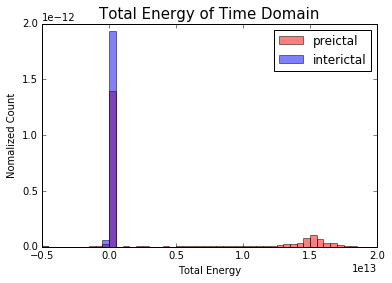

In [69]:
#channel 0
energy_result = energy(interictal,preictal,plot = 1)

### Skewness

In [72]:
def skewness(no,yes,channel = 0,upper_freq = 300,plot = 0):
    yes_result = []
    no_result = []
    upper_lim = upper_freq/5000. * 20000
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))[:upper_lim] #select a range of fft
        skew = ss.skew(fft)
        yes_result.append(skew)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))[:upper_lim] #select a range of fft
        skew = ss.skew(fft)
        no_result.append(skew)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1)
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1)
        plt.legend(loc = "best")
        plt.title("Skewness of Frequency Domain",fontsize = 15)
        plt.xlabel("Skewness")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Skewness.png', format='png', dpi=1000)
        plt.show()

    return np.concatenate((no_result,yes_result))

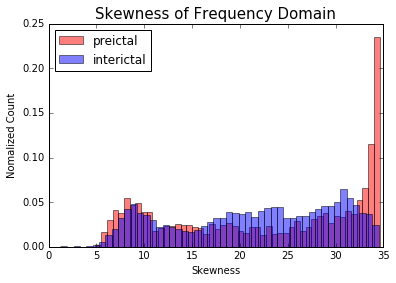

In [73]:
#channel 0
skewness_result = skewness(interictal,preictal,channel=0,upper_freq = 300,plot = 1)

### Kurtosis

In [74]:
def kurtosis(no,yes,channel = 0,upper_freq = 300,plot = 0):
    yes_result = []
    no_result = []
    upper_lim = upper_freq/5000. * 20000
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))[:upper_lim] #select a range of fft
        kurt = ss.kurtosis(fft)
        yes_result.append(kurt)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))[:upper_lim] #select a range of fft
        kurt = ss.kurtosis(fft)
        no_result.append(kurt)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1)
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1)
        plt.legend(loc = "best")
        plt.title("Kurtosis of Frequency Domain",fontsize = 15)
        plt.xlabel("Kurtosis")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Kurtosis.png', format='png', dpi=1000)
        plt.show()

    return np.concatenate((no_result,yes_result))

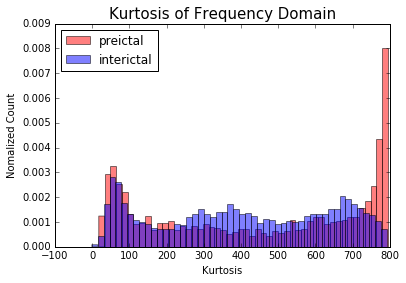

In [75]:
#channel 0
kurt_result = kurtosis(interictal,preictal,channel=0,upper_freq = 200,plot = 1)

### Time Variance

In [92]:
def variance_time(no,yes,channel = 0,plot = 0):
    yes_result = []
    no_result = []
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        var = np.var(abs(eeg))
        yes_result.append(var)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        var = np.var(abs(eeg))
        no_result.append(var)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1,range = (300,20000))
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1,range = (300,20000))
        plt.legend(loc = "best")
        plt.title("Variance of Time Domain",fontsize = 15)
        plt.xlabel("Variance")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Variance Time.png', format='png', dpi=1000)
        plt.show()
    
    return np.concatenate((no_result,yes_result))

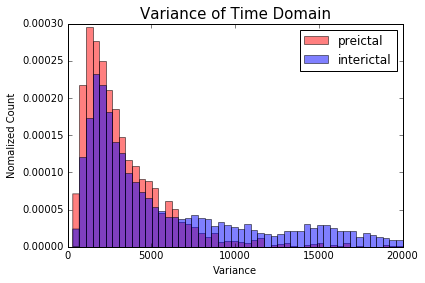

In [93]:
var_time = variance_time(interictal,preictal,plot = 1)

### Time Mean

In [104]:
def mean_time(no,yes,channel = 0,plot = 0):
    yes_result = []
    no_result = []
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        var = np.mean(abs(eeg))
        yes_result.append(var)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        var = np.mean(abs(eeg))
        no_result.append(var)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1,range = (0,600))
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1,range = (0,600))
        plt.legend(loc = "best")
        plt.title("Mean of Time Domain",fontsize = 15)
        plt.xlabel("Mean")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Mean Time.png', format='png', dpi=1000)
        plt.show()
    
    
    return np.concatenate((no_result,yes_result))

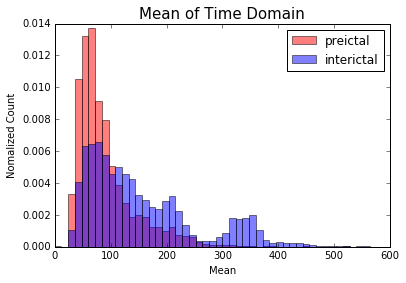

In [105]:
mean_t = mean_time(interictal,preictal,plot = 1)

### Frequency Variance

In [112]:
def variance_freq(no,yes,channel = 0,upper_freq = 200,plot=0):
   
    yes_result = []
    no_result = []
    upper_lim = upper_freq/5000. * 20000
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))[:upper_lim]
        var = np.mean(fft)
        yes_result.append(var)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))[:upper_lim]
        var = np.mean(fft)
        no_result.append(var)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1,range = (0,10000000))
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1,range = (0,10000000))
        plt.legend(loc = "best")
        plt.title("Variance of Frequency Domain",fontsize = 15)
        plt.xlabel("Variance")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Variance Freq.png', format='png', dpi=1000)
        plt.show()
    
    return np.concatenate((no_result,yes_result))

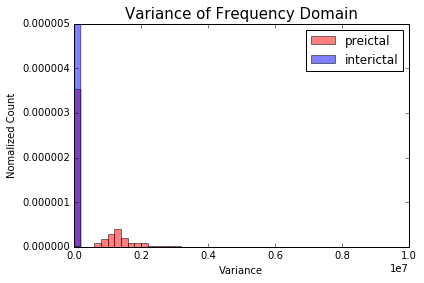

In [113]:
var_freq = variance_freq(interictal,preictal,plot = 1)

### Entropy

In [121]:
def entropy(no,yes,bands_freq,channel = 0,plot = 0):
    yes_result = []
    no_result = []
    bands = [freq * 4 for freq in bands_freq]
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))
        bands_energy = []
        
        for i in range(0,len(bands) - 1):
            band_energy = np.sum(np.power(fft[bands[i]:bands[i+1]],2))
            bands_energy.append(band_energy)
                
        entropy = ss.entropy(bands_energy)
        yes_result.append(entropy)
        
        
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))
        bands_energy = []
        
        for i in range(0,len(bands) - 1):
            band_energy = np.sum(np.power(fft[bands[i]:bands[i+1]],2))
            bands_energy.append(band_energy)
                
        entropy = ss.entropy(bands_energy)
        no_result.append(entropy)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1)
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1)
        plt.legend(loc = "best")
        plt.title("Energy Entropy",fontsize = 15)
        plt.xlabel("Energy Entropy")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Energy Entropy.png', format='png', dpi=1000)
        plt.show()
    
    return np.concatenate((no_result,yes_result))

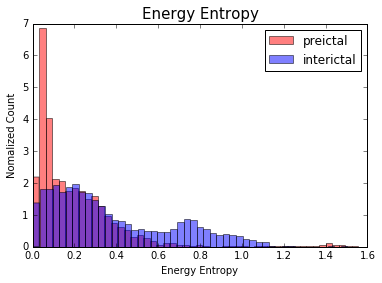

In [117]:
#By trying different bands selection and analyze the frequency energy distribution, we have select the bands to be below
bands = [0,0,10,50,100,200,300,400,2500]
entropy = entropy(interictal,preictal,bands,channel=0,plot = 1)

### Brightness

In [124]:
def brightness(no,yes,thres_fre,channel = 0,plot = 0):
    yes_result = []
    no_result = []
    thres = thres_fre * 4 
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))     
        energy = np.sum(np.power(fft[thres:10000],2))
        bright = energy / np.sum(np.power(fft[:10000],2))
        yes_result.append(bright)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))     
        energy = np.sum(np.power(fft[thres:10000],2))
        bright = energy / np.sum(np.power(fft[:10000],2))
        no_result.append(bright)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1)
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1)
        plt.legend(loc = "best")
        plt.title("Brightness",fontsize = 15)
        plt.xlabel("Brightness")
        plt.ylabel("Nomalized Count")
        plt.savefig('EEG Feature Brightness.png', format='png', dpi=1000)
        plt.show()
    
    
    return np.concatenate((no_result,yes_result))

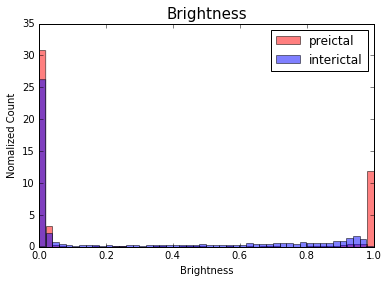

In [125]:
bright = brightness(interictal,preictal,25,plot = 1)

### Energy distribution

In [135]:
def Energy_distribution(no,yes,band,channel = 0,plot = 0):
    yes_result = []
    no_result = []
    thres = band * 4 
    
    for i in range(len(yes)):
        eeg = yes[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))     
        energy = np.sum(np.power(fft[thres[0]:thres[1]],2))
        bright = energy# / np.sum(np.power(fft[:10000],2))
        yes_result.append(bright)
        
    for i in range(len(no)):
        eeg = no[i][channel,:]
        fft = abs(scipy.fftpack.fft(eeg))     
        energy = np.sum(np.power(fft[thres[0]:thres[1]],2))
        bright = energy# / np.sum(np.power(fft[:10000],2))
        no_result.append(bright)
        
    #plot histogram
    if (plot):
        plt.hist(yes_result,50,color = "r", alpha = 0.5,label = "preictal",normed=1,range = [0,1e14])
        #plt.show()

        plt.hist(no_result,50,color = "b", alpha = 0.5,label = "interictal",normed=1,range = [0,1e14])
        plt.legend(loc = "best")
#         plt.title("Brightness",fontsize = 15)
#         plt.xlabel("Brightness")
#         plt.ylabel("Nomalized Count")
#         plt.savefig('EEG Feature Brightness.png', format='png', dpi=1000)
#         plt.show()
    
    
    return np.concatenate((no_result,yes_result))

array([  1.02446238e+13,   9.26430094e+12,   7.65345410e+12, ...,
         9.51949858e+11,   5.71004213e+12,   1.94623936e+12])

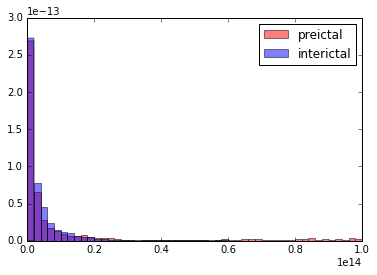

In [136]:
Energy_distribution(interictal,preictal,[0,4],plot = 1)

# Concatenate Different Features for 15 Channels

In [27]:
def get_data(interictal,preictal):
    bands = [0,0,10,50,100,200,300,400,2500]
    data = pd.DataFrame({})
    for i in range(15):
        
        energy_result = energy(interictal,preictal,channel=i)
        skewness_result = skewness(interictal,preictal,channel=i,upper_freq = 300)
        kurt_result = kurtosis(interictal,preictal,channel=i,upper_freq = 200)
        print "yes"
        var_time_result = variance_time(interictal,preictal,channel=i)
        mean_time_result = mean_time(interictal,preictal,channel=i)
        var_freq_result = variance_freq(interictal,preictal,channel=i)
        entropy_result = entropy(interictal,preictal,bands,channel=i)
        print "yes"
        bright_result = brightness(interictal,preictal,25,channel = i)
        
        temp = pd.DataFrame({
                "total_energy_time" + str(i+1):energy_result,
                "brightness" + str(i+1): bright_result,
                "entropy" + str(i+1): entropy_result,
                "mean_time" + str(i+1):mean_time_result,
                "variance_time" + str(i+1):var_time_result,
                "variance_freq" + str(i+1):var_freq_result,
                "kurtosis" + str(i+1): kurt_result,
                "skewness" + str(i+1): skewness_result
                            })
        
        data = pd.concat((data,temp),axis = 1)
    return data

In [29]:
data_15 = get_data(interictal,preictal)
data_15.head()

,brightness1,entropy1,kurtosis1,mean_time1,skewness1,total_energy_time1,variance_freq1,variance_time1,brightness2,entropy2,...,variance_freq14,variance_time14,brightness15,entropy15,kurtosis15,mean_time15,skewness15,total_energy_time15,variance_freq15,variance_time15
0,0.000880,0.043625,721.094193,158.76020,32.194713,131706224,11856.739156,2751.799696,0.000091,0.006461,...,54871.902462,20660.609164,0.000519,0.036612,764.198325,512.79630,33.570623,-11489614,31048.218837,11742.888406
1,0.001198,0.044445,729.649922,151.27660,32.442783,185629188,11977.381395,2259.838492,0.000086,0.005487,...,51818.693210,13431.091283,0.000585,0.038867,757.598846,491.23910,33.348356,8307888,31946.636490,13221.934631
2,0.001749,0.055361,696.690766,137.54860,31.356172,189459474,12532.309416,2890.508338,0.000112,0.007443,...,48733.568904,8357.453740,0.000549,0.030244,762.664183,454.28490,33.521525,10043944,27632.566455,9652.393232
3,0.007771,0.151379,599.234926,158.35565,28.070734,118714079,20658.297312,7319.352063,0.006053,0.064512,...,47826.564831,9343.361726,0.001381,0.054074,724.933648,340.27445,32.264381,-21545403,27297.634978,12232.118127
4,0.000761,0.034017,722.932694,177.11865,32.271204,61907609,12660.416100,3306.162672,0.000104,0.006273,...,50079.385995,18405.943875,0.000979,0.054537,723.546438,402.08115,32.226772,8140531,31631.492098,16972.757765


In [30]:
#save predictors to file
data_15.to_csv("eeg_patient_1.csv",sep = ",",index_label = False)

In [31]:
#save response to file 
y = np.concatenate((np.zeros(len(interictal)),np.repeat([1],len(preictal))))
print len(y)
cPickle.dump(y, open('y_patient_1.p', 'wb')) 

10200
